In [27]:
from importlib import reload
from pyfvtool import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
from tqdm import tqdm

import sys
sys.path.append('..')
from pymadreq import *
import pymadreq.coreflood as cf
import pymadreq.fractional_flow as ff
import pymadreq.IO as IO

reload(ff)
reload(cf)
reload(IO)

<module 'pymadreq.IO' from 'd:\\projects\\github\\PyMADREQ\\examples\\..\\pymadreq\\IO.py'>

## Reading input file and defining the domain

In [28]:
# read the input file
data = IO.read_json("../examples/sample.json")
rel_perm_ww, rel_perm_ow, pc_ww, pc_ow = IO.read_transport_functions(data)
core_plug = IO.read_core_properties(data)
fluids = IO.read_fluids(data)
IC = IO.read_initial_conditions(data) # initial conditions
BC = IO.createFloodingCondition(data["BC"]) # boundary conditions
numerical_params = IO.read_numerical_settings(data)
m = IO.read_flooding_domain(data)

In [29]:
cf_1d = cf.CoreFlooding1D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=50
)

In [30]:
t_num, R_num, dp_num = cf_1d.simulate_no_pc()

## Transport properties

In [31]:
xt_shock, sw_shock, xt_prf, sw_prf, t_ana, p_inj_ana, R_oil_ana = ff.frac_flow_wf(
    fluids, rel_perm_ww, core_plug, IC, ut=cf_1d.u_inj, sw_inj=1.0, pv_inj=3.0)

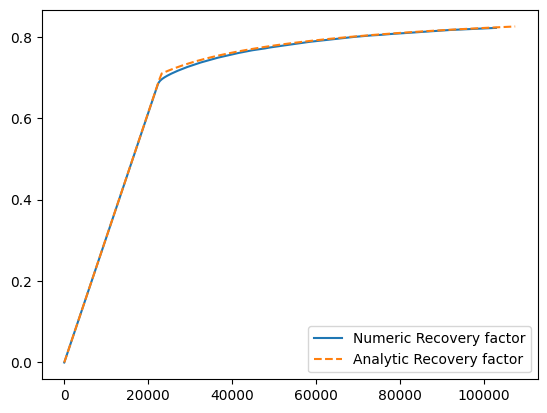

In [32]:
plt.plot(t_num, R_num, label= 'Numeric Recovery factor')
plt.plot(t_ana, R_oil_ana, '--', label= 'Analytic Recovery factor')
plt.legend()

In [33]:
cf_1d.final_sw.value


array([1.10581433, 0.89418567, 0.89070516, 0.88754271, 0.88455537,
       0.88169169, 0.87892601, 0.87624307, 0.87363268, 0.87108751,
       0.86860196, 0.86617156, 0.86379263, 0.86146203, 0.85917706,
       0.85693536, 0.8547348 , 0.85257349, 0.85044969, 0.84836182,
       0.84630843, 0.84428816, 0.84229976, 0.84034205, 0.83841395,
       0.83651443, 0.8346425 , 0.83279726, 0.83097791, 0.82918342,
       0.82741333, 0.82566636, 0.82394275, 0.82224199, 0.82055798,
       0.81890213, 0.81726668, 0.81563578, 0.81403859, 0.81245269,
       0.81100655, 0.80909279, 0.80808402, 0.80618285, 0.80502703,
       0.80297892, 0.80157255, 0.80125338, 0.80107502, 0.77678418,
       0.78378253, 0.78378253])

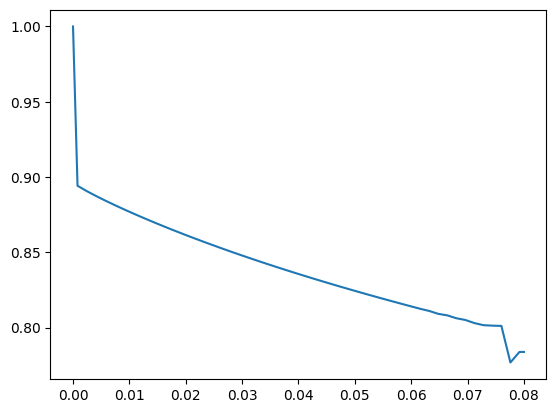

In [34]:
visualizeCells(cf_1d.final_sw)

## Fittin model to core flooding data

In [ ]:
# using lmfit to fit a two-phase model to a dataset
from lmfit import minimize, Parameters
def residual(params, x, data, uncertainty):
    amp = params['amp']
    phaseshift = params['phase']
    freq = params['frequency']
    decay = params['decay']

    model = amp * np.sin(x*freq + phaseshift) * np.exp(-x*x*decay)

    return (data-model) / uncertainty


params = Parameters()
params.add('amp', value=10)
params.add('decay', value=0.007)
params.add('phase', value=0.2)
params.add('frequency', value=3.0)

out = minimize(residual, params, args=(x, data, uncertainty))